In [1]:
from autograd import numpy as np
import matplotlib.pyplot as plt

% matplotlib inline

import matplotlib as mpl
mpl.style.use('seaborn-colorblind')

#To make sure we have always the same matplotlib settings
#(the ones in comments are the ipython notebook settings)

mpl.rcParams['figure.figsize']=(12.0,9.0)    #(6.0,4.0)
mpl.rcParams['font.size']=20               #10 
mpl.rcParams['savefig.dpi']= 200             #72 
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
from matplotlib import rc
mpl.rcParams["font.family"] = "Times New Roman"

colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']

from astropy import units as u

shift = np.fft.fftshift
fft   = np.fft.fft2
ifft  = np.fft.ifft2
fftfreq = np.fft.fftfreq

dtor = np.pi/180.0


In [164]:
def make_pupil(radius,npix=128,rtot=20*u.m,offset=0.):
    x = np.linspace(-npix/2.,npix/2.,npix)-offset
    x = x*rtot/npix
    xx, yy = np.meshgrid(x,x)
    
    rr = np.sqrt(xx**2 + yy**2)
    mask = rr > radius
    pupil = np.ones_like(rr)
    pupil[mask] = 0
    return pupil.value


In [115]:
npix = 128
rtot=20*u.m
x = np.linspace(-npix/2.,npix/2.,npix)#-0.5
x = x*rtot/npix
xx, yy = np.meshgrid(x,x)

rr = np.sqrt(xx**2 + yy**2)

In [116]:
rr[0,:]

<Quantity [14.14213562, 14.0312221 , 13.9212064 , 13.81210996, 13.70395474,
           13.59676321, 13.49055833, 13.38536359, 13.28120299, 13.17810105,
           13.07608282, 12.97517386, 12.87540025, 12.77678858, 12.67936598,
           12.58316004, 12.48819891, 12.39451117, 12.30212594, 12.21107277,
           12.12138168, 12.03308313, 11.94620799, 11.86078755, 11.77685346,
           11.69443772, 11.61357265, 11.53429088, 11.45662527, 11.3806089 ,
           11.30627506, 11.23365712, 11.16278859, 11.09370299, 11.02643384,
           10.96101456, 10.89747849, 10.83585875, 10.77618821, 10.71849942,
           10.66282455, 10.60919531, 10.55764287, 10.50819779, 10.46088997,
           10.41574851, 10.3728017 , 10.33207692, 10.29360053, 10.25739784,
           10.223493  , 10.19190894, 10.1626673 , 10.13578835, 10.11129094,
           10.08919241, 10.06950857, 10.05225358, 10.03743999, 10.0250786 ,
           10.01517851, 10.00774701, 10.00278962, 10.00031   , 10.00031   ,
           1

In [100]:
pupil = make_pupil(3*u.m)

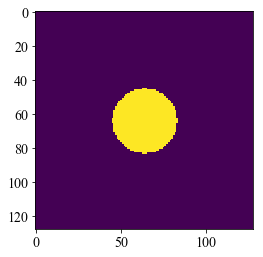

In [101]:
plt.imshow(pupil)

In [103]:
x.min(),x.max()

(-64.0, 64.0)

In [17]:
# =========================================================================
# =========================================================================

def mas2rad(x):
    ''' Convenient little function to convert milliarcsec to radians '''
    return x*np.pi/(180*3600*1000)

# =========================================================================
# =========================================================================

def rad2mas(x):
    ''' Convenient little function to convert radians to milliarcseconds '''
    return x/np.pi*(180*3600*1000)


In [60]:
fftshift = np.fft.fftshift
fft = np.fft.fft2

def propagate(pupil):
    scale = pupil
    return fftshift(fft(fftshift(pupil)))

In [65]:
psf = propagate(pupil)

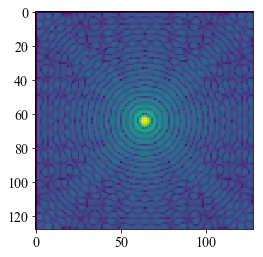

In [66]:
plt.imshow(np.abs(psf)**0.25)
# plt.xlim(500,524)
# plt.ylim(500,524)

In [30]:
uv = fftshift(fft((np.abs(psf)**2)))

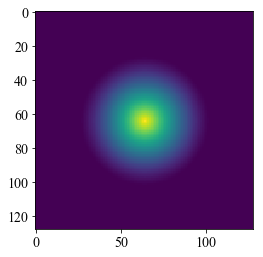

In [31]:
plt.imshow(np.abs(uv))

In [32]:
from autograd import grad, elementwise_grad, jacobian

In [44]:
def get_psf(screen):
    return propagate(pupil*np.exp(1.j*screen))
    
def get_uv(psf):
    return fftshift(fft(fftshift(np.abs(psf)**2)))

def get_phases(screen):
    return np.angle(get_uv(get_psf(screen)))

In [45]:
from scipy.signal import correlate2d, convolve2d

In [46]:
support = convolve2d(pupil,pupil,mode='same')>0

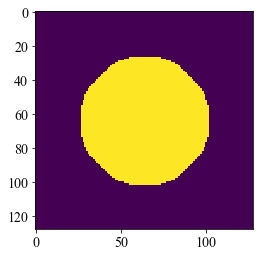

In [47]:
plt.imshow(support)

In [48]:
phasegrad = jacobian(get_phases)

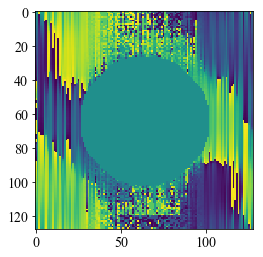

In [49]:
plt.imshow((get_phases(pupil)))


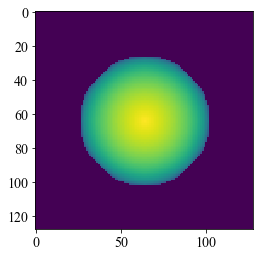

In [71]:
plt.imshow(np.abs(get_uv(psf))**0.2)

In [72]:
%%time 
thisgrad = phasegrad(np.zeros_like(pupil))

CPU times: user 34 s, sys: 2.06 s, total: 36.1 s
Wall time: 36.2 s


In [73]:
get_phases(np.zeros_like(pupil))

array([[ 0.        , -0.03563907, -2.97633245, ...,  2.31162827,
         3.05284211, -0.3611106 ],
       [ 0.04911063,  0.04349599,  2.98009348, ...,  2.13064692,
         2.90743327, -0.23452814],
       [ 0.0790944 ,  0.11184858,  2.72881318, ...,  2.05924696,
         2.80638216, -0.14203692],
       ...,
       [-0.12361345, -0.26423628, -2.38469299, ..., -2.8603063 ,
        -2.8776247 , -0.66605477],
       [-0.0790944 , -0.18395073, -2.49738059, ...,  3.09399191,
        -2.97522217, -0.55375132],
       [-0.04911063, -0.12153579, -2.67219938, ...,  2.65160138,
        -3.09005951, -0.46814683]])

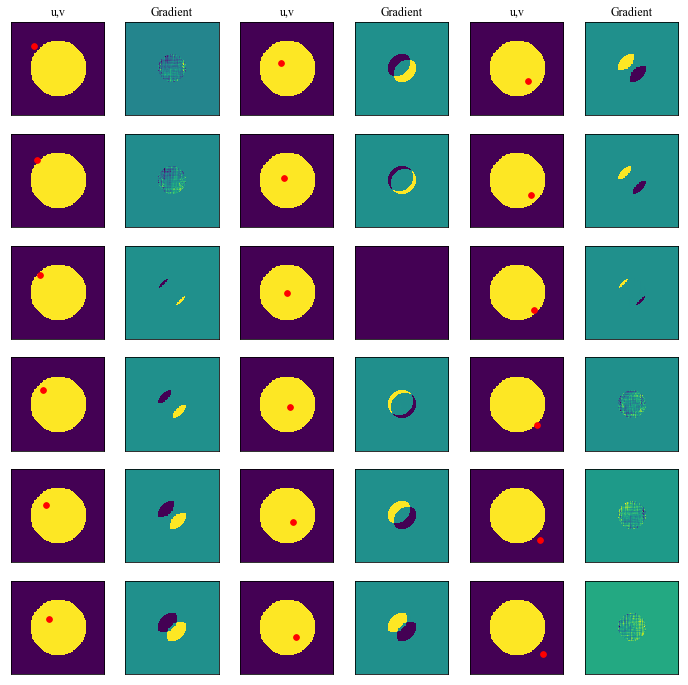

In [74]:
fig, ax = plt.subplots(6,6,figsize=(12, 12))
columns = 2
rows = 6
indices = 32


for j in [0,2,4]:
    for i in range(rows):
#         print(indices)
        ax[i,1+j].imshow(thisgrad[indices,indices,:,:])
        ax[i,1+j].set_xticks([])
        ax[i,1+j].set_yticks([])
        if i ==0:
            ax[i,1+j].set_title('Gradient')
            ax[i,j].set_title('u,v')

        ax[i,j].imshow(support)
        ax[i,j].scatter(indices,indices,s=32,c='r')
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        indices += 4

plt.savefig('jacobian.png',bbox_inches='tight')

### Now let's try a coronagraph!

In [121]:
x = np.linspace(-psf.shape[0]/2.,psf.shape[0]/2.,psf.shape[0])


In [122]:
x.min(),x.max()

(-64.0, 64.0)

In [125]:
xx, yy = np.meshgrid(x,x)
xx.min(),xx.max()

(-64.0, 64.0)

In [144]:
def make_stop(psf):
    x = np.linspace(-psf.shape[0]/2.,psf.shape[0]/2.,psf.shape[0])-0.5
    xx, yy = np.meshgrid(x,x)
    
    rr = np.sqrt(xx**2 + yy**2)
    mask = rr < 8.
    stop = np.ones_like(rr)
    stop[mask] = 0
    return stop



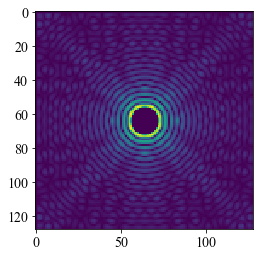

In [145]:
stop = make_stop(psf)
stopped = stop*psf
plt.imshow(np.abs(stopped))

In [191]:
lyot = make_pupil(3*u.m*0.85,npix=128,rtot=20*u.m,offset=1)

In [192]:
lyot_plane = propagate(stopped)

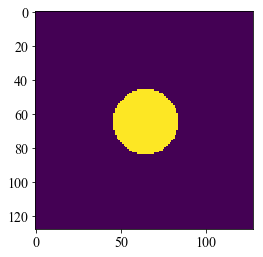

In [193]:
test = (propagate(psf))
plt.imshow(np.abs(test)**0.25)

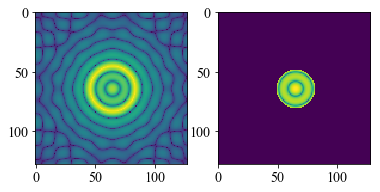

In [194]:
f, (ax1,ax2) = plt.subplots(1,2)
ax1.imshow(np.abs(lyot_plane)**0.2)
ax2.imshow(np.abs(lyot_plane*lyot)**0.2)

In [195]:
final = propagate(lyot_plane*lyot)

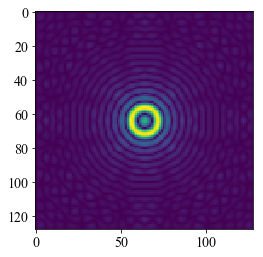

In [196]:
plt.imshow(np.abs(final))

In [197]:
def get_speckles(screen):
    return np.abs(propagate(lyot*propagate(stop*get_psf(screen))))

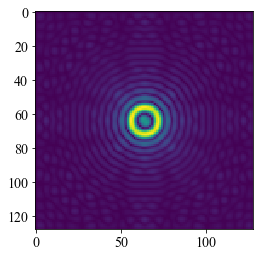

In [198]:
speckles = get_speckles(np.zeros_like(pupil))
plt.imshow(np.abs(speckles))

In [199]:
speckle_grad = jacobian(get_speckles)

In [200]:
%%time 
new_grad = speckle_grad(np.zeros_like(pupil))

CPU times: user 41.6 s, sys: 2.45 s, total: 44 s
Wall time: 44.2 s


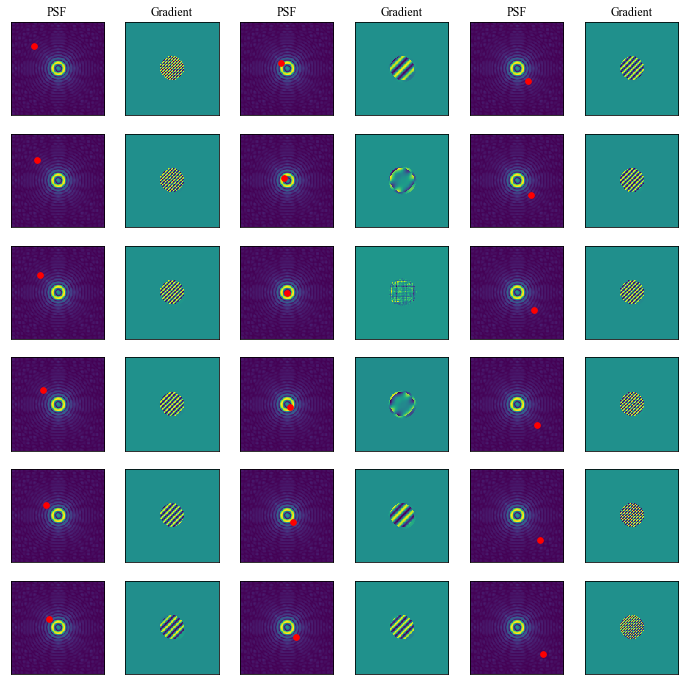

In [202]:
fig, ax = plt.subplots(6,6,figsize=(12, 12))
columns = 2
rows = 6
indices = 32


for j in [0,2,4]:
    for i in range(rows):
#         print(indices)
        ax[i,1+j].imshow(new_grad[indices,indices,:,:])
        ax[i,1+j].set_xticks([])
        ax[i,1+j].set_yticks([])
        if i ==0:
            ax[i,1+j].set_title('Gradient')
            ax[i,j].set_title('PSF')

        ax[i,j].imshow(speckles)
        ax[i,j].scatter(indices,indices,s=32,c='r')
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        indices += 4

plt.savefig('speckle_jacobian.png',bbox_inches='tight')

### Let's make this into a phase transfer matrix

In [203]:
new_grad.shape

(128, 128, 128, 128)

In [204]:
test = np.reshape(new_grad,(128**2,128**2))

In [205]:
test.shape

(16384, 16384)

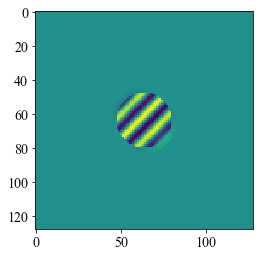

In [206]:
plt.imshow(np.reshape(test,(128,128,128,128))[55,55,:,:])

In [210]:
transfer = new_grad[:,:,pupil>0].reshape(128**2,np.sum(pupil>0))

In [211]:
transfer.shape

(16384, 1137)

In [213]:
%%time
u, s, v = np.linalg.svd(transfer)

CPU times: user 3min 9s, sys: 3.96 s, total: 3min 13s
Wall time: 57.8 s


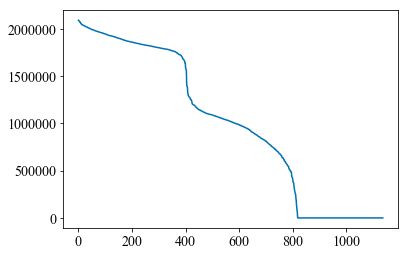

In [215]:
plt.plot(s)